# VLBI

In [15]:
# # convert entry from Marcellin's file into flat DB
# DB = {}
# bandwidths = set()
# filters = set(['avg'])
# integrations = set()
# fovs = set()
# def addentry (md,avgonly=False):
#     # adds single "Marcellin dict" entry corresponding to one bandwidth's entry
#     bw = float(md['bandwidth'][:-3])  # trim "MHz" at end
#     bandwidths.add(bw)
#     for intkey, md1 in md.iteritems():
#         if not intkey.startswith('int'):
#             continue
#         integr = float(intkey[:-1][3:]) # trim off 'int' and 's'
#         integrations.add(integr)
#         radius = md1['radius']
#         if 'Avg' in md1 and 'flux' in md1['Avg']:
#             DB[bw,integr,'avg',None] = md1['Avg']['flux'], md1['Avg']['noise'], radius
#         if not avgonly:
#             fov = 1
#             fovs.add(fov)
#             for filt, md3 in md1.iteritems():
#                 if filt != 'Avg' and filt != 'radius':
#                     print md3
#                     DB[bw,integr,filt,fov] = md3['flux'], md3['noise'], radius
#                     filters.add(filt)
# convert entry from Marcellin's file into flat DB
DB = {}
bandwidths = set()
filters = set(['avg'])
integrations = set()
fovs = set()
def addentry (md):
    # adds single "Marcellin dict" entry corresponding to one bandwidth's entry
    bw = float(md['bandwidth'][:-3])  # trim "Mhz" at end
    bandwidths.add(bw)
    for intkey, md1 in md.iteritems():
        if not intkey.startswith('int'):
            continue
        integr = float(intkey[:-1][3:]) # trim off 'int' and 's'
        integrations.add(integr)
        radius = md1['radius']
        if 'avg' in md1 and 'flux' in md1['avg']:
            DB[bw,integr,'avg',None] = md1['avg']['flux'], md1['avg']['noise'], radius
        for fovkey, md2 in md1.iteritems():
            if not fovkey.startswith('FoV'):
                continue
            fov = float(fovkey[:-3][3:])
            fovs.add(fov)
            for filt, md3 in md2.iteritems():
                DB[bw,integr,filt,fov] = md3['flux'], md3['noise'], radius
                filters.add(filt)

In [16]:
FIGDPI=100
%matplotlib inline
import pylab as plt
import cPickle
import glob
for filename in glob.glob("VLBI-int0.1s-12500Hz-structure-in-order.data"):
    a1 = cPickle.load(open(filename))
    for km,md in a1.iteritems():
        addentry(md)
# a1 = cPickle.load(open('picklefile_chandwidth-1Mhz_int-25s-50s-100s_FoV-1-2-4deg_overlaps.txt'))
# a2 = cPickle.load(open('picklefile_chandwidth-2Mhz_int-25s-50s-100s_FoV-1-2-4deg_overlaps.txt'))
# a3 = cPickle.load(open('picklefile_chandwidth-4Mhz_int-25s-50s-100s_FoV-1-2-4deg_overlaps.txt'))
# a4 = cPickle.load(open('picklefile_chandwidth-10Mhz-int-100s_2.5Mhz-int-25s_FoV-1-2-4deg_overlaps.txt'))

In [17]:
# addentry(a1)
# addentry(a2)
# for km,md in a3.iteritems():
#     addentry(md)
# for km,md in a4.iteritems():
#     addentry(md)
BANDWIDTHS = sorted(bandwidths)
INTEGRATIONS = sorted(integrations)
FILTERS = sorted(filters)
FOVS = sorted(fovs)
print BANDWIDTHS, INTEGRATIONS, FOVS, FILTERS
print DB.keys()

[0.0125] [0.1] [0.7] ['avg', 'bessel-1x1', 'sinc-1x1']
[(0.0125, 0.1, 'bessel-1x1', 0.7), (0.0125, 0.1, 'sinc-1x1', 0.7), (0.0125, 0.1, 'avg', None)]


In [18]:
# print a1.keys(),a2.keys(),a3.keys(),a4.keys()
# a3 = a3['bandwidth4Mhz']
# a4 = a4['bandwidth10Mhz']
# print a3.keys(),a4.keys(),a4['int25s']['avg']

In [19]:
# int50 = a3['int50s']
# fovs = ['FoV1deg', 'FoV2deg', 'FoV4deg' ]
# integrations =  ['int25s', 'int50s', 'int100s' ]
# radius = int50['radius']
# filters = int50['FoV1deg'].keys()
# print filters

In [20]:
ALLSYMS = "*osdv^sp<>1234+x"
ALLSTYLES = [ 'r-', 'b--', 'g:' ]
import fnmatch
import itertools
def plotfov (fov, bw, filters="*", integrations=INTEGRATIONS, relative=False, legloc=None):
    """Makes a plot for one FoV, one BW, given integrations and filters.
    Filters may be a list of strings, or a wildcard"""
    if type(filters) is str:
        matches = [ fnmatch.filter(FILTERS, filt) for filt in filters.split() ]
        filters = list(itertools.chain(*matches))
    if relative:
        plt.axhline(1, color="0.8", lw=10)
    for style,ints in enumerate(integrations):
        if (bw,ints,'Avg',None) not in DB:
            continue
        color = ALLSTYLES[style%len(ALLSTYLES)]
        flux0, noise0, radius0 = DB[bw,ints,'avg',None]
        if not relative:
            plt.plot(radius0, flux0, color="0.8", lw=10, label='avg %ss'%ints, zorder=-1000)
        for filt, ls in zip(filters, ALLSYMS):
            if (bw,ints,filt,fov) in DB:
                flux, noise, radius = DB[bw,ints,filt,fov]
                ratio = "$\Xi$=%.2f F=%.1f" % (noise/noise0,flux0[-1]/flux[-1])
                if relative:
                    flux = flux/flux0
                plt.plot(radius, flux, color+ls, mec=color[0], ms=7, 
                         label='%s %ss %s'%(filt, ints, ratio))
    plt.legend(loc=legloc or ("lower left" if relative else "upper right"))
    plt.xlabel("Distance from phase centre, degrees")
    if relative:
        plt.ylabel("Smearing performance relative to boxcar averaging")
        plt.title("Relative BDWF performance for FoV %d deg, bandwidth %d MHz" % (fov,bw) )
    else:
        plt.ylabel("Smearing factor")
        plt.title("Smearing for FoV %d deg, bandwidth %d MHz" % (fov,bw) )
def plotallfovs (bw, filters="*", integrations=INTEGRATIONS):
    """Makes a plot for one BW, all FoVs, integrations and filters"""
    for ifov, fov in enumerate(FOVS):
        plt.figure(figsize=(16,30))
        plt.subplot(len(fovs),1,ifov+1)
        plotfov(fov,bw,filters=filters,integrations=integrations)
def plotallfovsrel (bw, filters='*',integrations=INTEGRATIONS):
    """Makes a plot for one BW, all FoVs, integrations and filters"""
    for ifov, fov in enumerate(FOVS):
        plt.figure(figsize=(16,30))
        plt.subplot(len(fovs),1,ifov+1)
        plotfov(fov,bw,filters=filters,integrations=integrations,relative=True)
def plotint (ints, bw, fovs=FOVS, filters="*", relative=False, legloc=None):
    """Makes a plot for one integration, one BW, given FoVs and filters.
    Filters may be a list of strings, or a wildcard"""
    if type(filters) is str:
        matches = [ fnmatch.filter(FILTERS, filt) for filt in filters.split() ]
        filters = list(itertools.chain(*matches))
    if (bw,ints,'avg',None) not in DB:
        print bw,ints
        raise RuntimeError,"no data for this bandwidth/integration"
    flux0, noise0, radius0 = DB[bw,ints,'avg',None] 
    if not relative:
        plt.plot(radius0, flux0, color="0.8", lw=10, label='avg %ss'%ints)
    else:
        plt.axhline(1, color="0.8", lw=10)
    for style, fov in enumerate(fovs):
        color = ALLSTYLES[style%len(ALLSTYLES)]
        for filt, symbol in zip(filters, ALLSYMS):
            if (bw,ints,filt,fov) in DB:
                flux, noise, radius = DB[bw,ints,filt,fov]
                ratio = "$\Xi=%.2f$" % (noise/noise0)
                if relative:
                    flux = flux/flux0
                plt.plot(radius, flux, color+symbol, mec=color[0], ms=7, 
                         label='%s FOV=%ddeg %ss %s'%(filt, fov, ints, ratio))
    plt.legend(loc=legloc or ("lower left" if relative else "upper right"))
    plt.xlabel("Distance from phase centre, degrees")
    if relative:
        plt.ylabel("Smearing performance relative to boxcar averaging")
        plt.title("Relative BDWF performance for %ds x %dMHz integration" % (ints,bw) )
    else:
        plt.ylabel("Smearing factor")
        plt.title("Smearing for %ds x %dMHz integration" % (ints,bw) )

# Specific plots

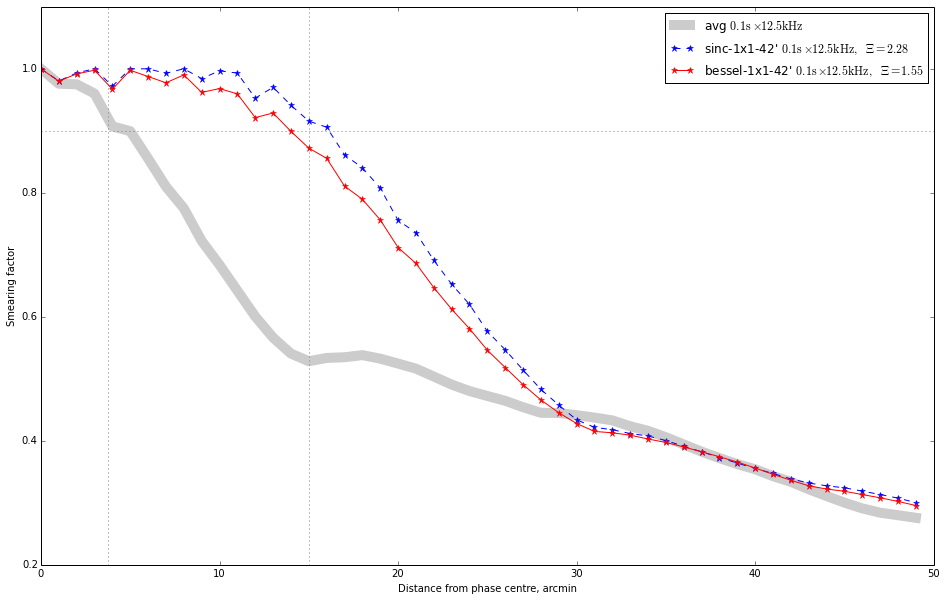

In [29]:
def plotlist (sequence, legloc=None, relative=False, xlines=[0.95], ylines=[]):
    """Makes a plot for a sequence of bw,ints,filt,fov keys"""
    style = ALLSTYLES[0]
    isym = 0
    noise0 = 0
    bw, ints = 4.0, 50.
    flux0 = None
    if relative:
        plt.axhline(1, color="0.8", lw=10)
    if xlines:
        for x in xlines:
            plt.axhline(x,color="0.5",ls=':')
    if ylines:
        for y in ylines:
            plt.axvline(y,color="0.5",ls=':')
    for seq in sequence:
        if seq == "avg":
            seq = "avg", None
        # "linestyle" or "Ns" "or XMHz"
        if type(seq) is str: 
            if seq.endswith("s"):
                ints = float(seq[:-1])
            elif seq.lower().endswith("mhz"):
                bw = float(seq[:-3])
            elif seq.lower().endswith("hz"):
                bw = float(seq[:-2])
            else:
                style = seq
                isym = 0
            continue
        filt, fov = seq
        dbkey = bw, ints, filt, fov
        if dbkey not in DB:
            print "WARNING: %s not in database" % str(dbkey)
            continue
        flux, noise, radius = DB[dbkey]
        if filt == "avg":
            noise0 = noise0 or noise
            if not relative or flux0 is not None:
                plt.plot(radius*60, flux/flux0 if relative else flux, color="0.8", lw=10, zorder=-1000, 
                     label='avg $%s\mathrm{s}\\times%s\mathrm{kHz}$'%(ints,bw*1e+3))
            if flux0 is None:
                flux0 = flux
        else:
            ratio = ",\;\Xi=%.2f" % (noise/noise0)
            symbol = ALLSYMS[isym]
            isym = (isym+1) % len(ALLSYMS)
            if relative:
                flux = flux/flux0
                plt.plot(radius*60, flux, style+symbol, mec=style[0], ms=7, 
                         label='%s-%d\' $%s\mathrm{s}\\times%s\mathrm{kHz}%s$'%(filt, fov*60, ints, bw*1e+3, ratio))
            else:
                plt.plot(radius*60, flux, style+symbol, mec=style[0], ms=7, 
                         label='%s-%d\' $%s\mathrm{s}\\times%s\mathrm{kHz}%s$'%(filt, fov*60, ints, bw*1e+3, ratio))
    plt.legend(loc=legloc or "upper right",framealpha=1)
    plt.xlabel("Distance from phase centre, arcmin")
    if relative:
        plt.ylabel("Smearing performance relative to boxcar averaging")
    else:
        plt.ylabel("Smearing factor")
plt.figure(figsize=(16,10))
plotlist(["0.1s","0.0125MHz", "avg", 
          "b--", ("sinc-1x1",0.7),
          "r-", ("bessel-1x1",0.7), 
    ],relative=False,ylines=[15,15/4.],xlines=[0.9])
plt.savefig("../Figures/suppression-vlbi.png",dpi=FIGDPI)


In [22]:
print DB[2.,25,"avg",None][1]
print DB[2.,50,"avg",None][1]
print DB[4.,100,"avg",None][1]
print DB[10.,100,"avg",None][1]
print DB[10.,100,"sinc-4x3",4][1]
print DB[4.,100,"sinc-4x3",4][1]
for key in DB.keys():
    if key[2] == "avg":
        print key,DB[key][1]

KeyError: (2.0, 25, 'avg', None)

# Remarks on freq vs time intervals
OK, we should have worked this out much earlier. There are $S=24\cdot3600=86400$ seconds in a day. In $t$ seconds of integration, a baseline $B$ with an East-West component of $B_x$ sweeps out an angle of $2\pi t/S$, and a length of $2\pi B_x t/S$.

Over a $\Delta\nu$ channel at frequency $\nu$, the effective baseline changes as $B\Delta\nu/\nu$.

So, to make the sampling bin comparable in the freq and time direction, we must have $2B_x\pi t/S = b\Delta\nu/\nu$, or $\Delta\nu=2\pi\nu (B_x/B) (t/S)$.

In [ ]:
S = 24*3600
def delta_nu (t, nu=1400, bx_over_b=1):
  return 2*math.pi*nu*t*bx_over_b/S
print delta_nu(100)
print delta_nu(10,nu=14000)

This gives us a very easy rule-of-thumb: at 1.4 GHz, on a fully East-West baseline, 100s is roughly 10MHz in terms of effective baseline change (i.e. effective smearing).  